In [2]:
%matplotlib inline

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import h5py
import numpy.ma as ma
import scipy
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d 
from astropy.stats import LombScargle
from scipy.signal import csd, correlate
from scipy.optimize import leastsq, fsolve, least_squares
import math

In [4]:
#Opening h5 data file, reading data into arrays, then closing file
file_name = '20110518.001_lp_5min-cal.h5'
hf = h5py.File(file_name, 'r')

altitude = np.array(hf['NeFromPower/Altitude'])
Ne_NoTr = np.array(hf['NeFromPower/Ne_NoTr'])
dtime = np.array(hf['Time/dtime'])
beam_range_array = np.array(hf['NeFromPower/Range'])
Bx_array = np.array(hf['Geomag/Bx']) 
By_array = np.array(hf['Geomag/By'])
Bz_array = np.array(hf['Geomag/Bz'])
Ne_error = np.array(hf['NeFromPower/dNeFrac'])

hf.close()


In [4]:
#Define functions used to filter data
def butter_lowpass(cutoff, fs, order):
    nyq = 0.5 * fs                    #Nyquist frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

In [8]:
Ne_NoTr.shape

(230, 4, 180)

In [5]:
# Ne array for all 4 beams
time_start = 110
time_end = 294
time_size = time_end - time_start
alt_start = 36
alt_end = 126
alt_size = alt_end - alt_start
Ne_NoTr_array = np.array(Ne_NoTr[time_start:time_end,:,alt_start:alt_end]) #function input

#Adding 24 to  all values in time array after UT resets to zero
dtime_shift = np.copy(dtime[110:294,:])
dtime_shift[160,1] += 24
dtime_shift[161:,:]+= 24
#Creating mean time array
dtime_shift_mean = np.mean(dtime_shift,axis=1) # function input

In [6]:
# Define function that takes in Ne_NoTr_array and returns relative Ne array
def rel_e_den_function(Ne_array,time_array):
    #Define time array w/ spacing similar to original time sampling
    t = np.linspace(time_array[0],time_array[-1],int(time_array.size))
    # Filter requirements.
    order = 6
    sampling_period_hr = t[1] - t[0]
    fs = float(1) / float(sampling_period_hr) # sampling frequency, Hz
    cutoff = float(1) / float(2) # desired cutoff frequency of the filter, Hz
    # Get the filter coefficients so we can check its frequency response.
    b, a = butter_lowpass(cutoff, fs, order)

    time_size = Ne_array.shape[0]
    alt_size = Ne_array.shape[2]
    # Setting arrays equal to zero array
    Ne_reg_sampled_array = np.zeros((4,time_size,alt_size))
    Ne_filtered_array = np.zeros((4,time_size,alt_size)) # background densities
    rel_e_densities = np.zeros((4,time_size,alt_size))
    for num in range(4):
        for i in range(alt_size):
            Ne_alt_bin = Ne_array[:,num,i] # 1-D Ne array for altitude 0 and pole 0
            Ne_alt_bin_m1 = ma.masked_less_equal(Ne_alt_bin,0) # masking negative electron densities
            Ne_alt_bin_m2 = np.ma.masked_invalid(Ne_alt_bin_m1) # masking NaN values
            #Matrix of indexes for nonzero (i.e. nonmasked) elements in Ne array
            Ne_index = ma.nonzero(Ne_alt_bin_m2)
            if len(Ne_index[0]) > 1:
                time_mask_removed = np.copy(time_array)
                # Setting masked values in time array to 0
                for j in range(time_size):
                    if np.isin(j,Ne_index) == False:
                        time_mask_removed[j] = 0
                # Removing zero values from time array   
                time_interp = time_mask_removed[np.nonzero(time_mask_removed)] 
                # Removing masked values from Ne array
                Ne_for_interp = ma.compressed(Ne_alt_bin_m2) 
                # Defining interpolation function for Ne (as function of time)
                interp_fun_Ne = interp1d(time_interp, Ne_for_interp,kind='cubic')
                #Setting up Ne arry
                t1 = time_interp[0]
                t2 = time_interp[-1]
                Ne_reg_sampled = np.piecewise(t, [t < t1, (t1 <= t) & (t <= t2), t > t2], [0, lambda t: interp_fun_Ne(t) , 0])
                #Filter data passed through filtfilt to get response curve
                Ne_filtered = filtfilt(b,a,Ne_reg_sampled)
            else:
                Ne_reg_sampled = np.zeros(time_size)
                Ne_filtered = np.zeros(time_size)
            Ne_reg_sampled_array[num,:,i] = Ne_reg_sampled 
            Ne_filtered_array[num,:,i] = Ne_filtered
        rel_e_densities[num,:,:] = (Ne_reg_sampled_array[num,:,:] - Ne_filtered_array[num,:,:]) / Ne_filtered_array[num,:,:]

    return Ne_reg_sampled_array,Ne_filtered_array,rel_e_densities,t

In [7]:
# generating Ne arrays and defining arrays (from beam0) to be used in plots
Ne_reg_array, Ne_background_array, rel_Ne_den_array,t = rel_e_den_function(Ne_NoTr_array,dtime_shift_mean)
Z1 = Ne_reg_array[0,:,:]
Z2 = rel_Ne_den_array[0,:,:]
Z3 = Ne_background_array[0,:,:]

C:\Users\casey\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [8]:
# Define a function that maps the relative electron densities 
# and the background onto an evenly
# spaced altitude array for each beam 

def reg_spaced_alt_fun(Ne_background,rel_Ne,altitude_array):
    time_size = rel_Ne.shape[1]
    alt_size = rel_Ne.shape[2]
    Ne_background_reg_spaced = np.zeros((4,time_size,alt_size))
    rel_Ne_reg_spaced = np.zeros((4,time_size,alt_size))
    alt_km = altitude[:,alt_start:alt_end] / 1000
    alt1 = alt_km[0,0]
    alt2 = alt_km[0,-1]
    for i in range(4):
        if alt1 < alt_km[i,0]:
            alt1 = alt_km[i,0]
    for i in range(4):
        if alt2 > alt_km[i,-1]:
            alt2 = alt_km[i,-1]
    alt_reg_spaced_array = np.linspace(alt1,alt2,alt_size)
    for num in range(4):
        alt_interp = alt_km[num,:]
        for i in range(time_size):
            Ne_back_alt_interp = Ne_background[num,i,:]
            Ne_alt_interp = rel_Ne[num,i,:]
            Ne_back_alt_interp_fun = interp1d(alt_interp, Ne_back_alt_interp, kind='cubic')
            Ne_alt_interp_fun = interp1d(alt_interp, Ne_alt_interp, kind='cubic')
            Ne_background_reg_spaced[num,i,:] = Ne_back_alt_interp_fun(alt_reg_spaced_array)
            rel_Ne_reg_spaced[num,i,:] = Ne_alt_interp_fun(alt_reg_spaced_array)
    return alt_reg_spaced_array,Ne_background_reg_spaced,rel_Ne_reg_spaced

In [9]:
alt_reg_spaced,Ne_background_reg_spaced,rel_Ne_reg_spaced = reg_spaced_alt_fun(Ne_background_array,rel_Ne_den_array,altitude)

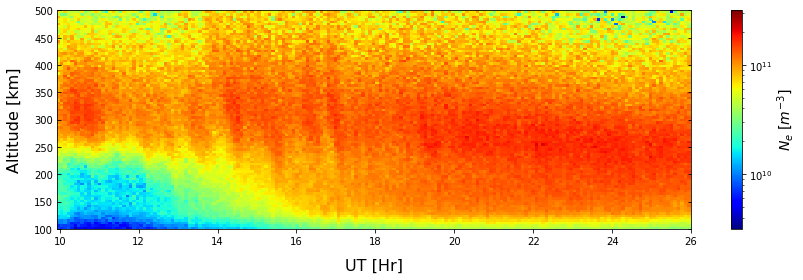

In [10]:
fig_size = ['','']
fig_size[0] = 12
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size
altitude_0 = np.array(altitude[0,36:126])
altitude_0_km = altitude_0 / 1000
ymin, ymax = altitude_0_km[0], altitude_0_km[-1]
yi = np.linspace(ymin,ymax,Ne_NoTr_array.shape[2])
Y, X = np.meshgrid(yi,t)
#Z1 = Ne_reg_sampled_array
fig, ax = plt.subplots()
im = ax.pcolormesh(X,Y,Z1, norm = colors.LogNorm(vmin = 10**9.5, vmax=10**11.5), cmap = plt.get_cmap('jet'))
ax.tick_params(axis = 'y',right=True, labelright=False, direction='in')
#lbs = ['','16','18','20','22','00','02']
#ax.set_xticklabels(lbs)
cbar = fig.colorbar(im, orientation = "vertical", pad = .05)
cbar.set_label('$N_e \ [m^{-3}]$',fontsize = 14)
#plt.title('Electron Densities')
plt.xlabel('UT [Hr]',fontsize = 16, labelpad = 12)
plt.ylabel('Altitude [km]',fontsize = 16, labelpad = 12)
plt.tight_layout()
plt.savefig('e_den_Negale.png')

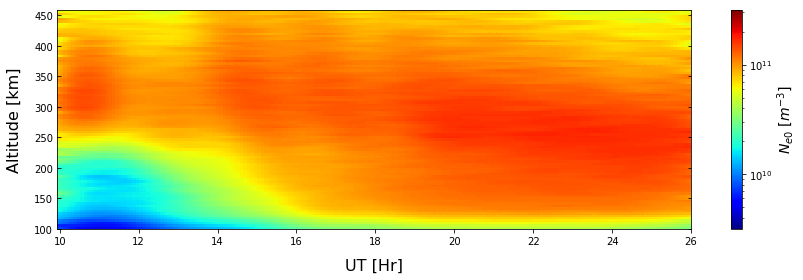

In [11]:
# plotting relative Ne density of regularly spaced altitude 
# derived from cubic interpolation in order to compare with original plot
fig_size = ['','']
fig_size[0] = 12
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size
Y, X = np.meshgrid(alt_reg_spaced,t)
fig, ax = plt.subplots()
im = ax.pcolormesh(X,Y,Ne_background_reg_spaced[0,:,:],norm = colors.LogNorm(vmin = 10**9.5, vmax=10**11.5), cmap = plt.get_cmap('jet'))
ax.tick_params(axis = 'y',right=True, labelright=False, direction='in')
cbar = fig.colorbar(im, orientation = "vertical", pad = .05)
cbar.set_label('$ N_{e0} \ [m^{-3}]$',fontsize = 14)
plt.xlabel('UT [Hr]',fontsize = 16, labelpad = 12)
plt.ylabel('Altitude [km]',fontsize = 16, labelpad = 12)
plt.tight_layout()
plt.savefig('background.png')

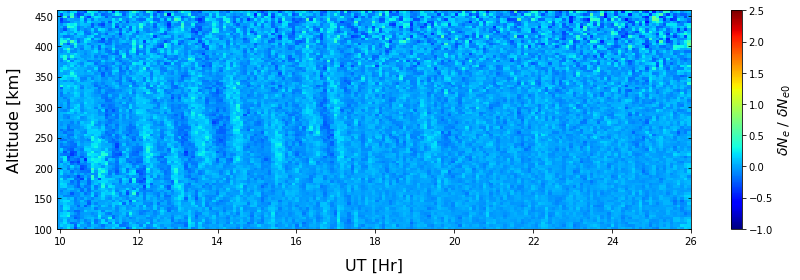

In [12]:
# plotting relative Ne density of regularly spaced altitude 
# derived from cubic interpolation in order to compare with original plot
fig_size = ['','']
fig_size[0] = 12
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size
Y, X = np.meshgrid(alt_reg_spaced,t)
Z3 = rel_Ne_reg_spaced[0,:,:]
fig, ax = plt.subplots()
im = ax.pcolormesh(X,Y,Z3, norm = colors.Normalize(vmin = -1, vmax=2.5), cmap = plt.get_cmap('jet'))
ax.tick_params(axis = 'y',right=True, labelright=False, direction='in')
cbar = fig.colorbar(im, orientation = "vertical", pad = .05)
cbar.set_label('$\delta N_e$ / $\delta N_{e0}$',fontsize = 14)
plt.xlabel('UT [Hr]',fontsize = 16, labelpad = 12)
plt.ylabel('Altitude [km]',fontsize = 16, labelpad = 12)
plt.tight_layout()
plt.savefig('relative_e_den_Negale_reg_spaced_alt.png')

In [11]:
# parameters for slice of defined MSTID event
alt_slice = alt_reg_spaced[13:63]
t_slice = t[0:90]
Ne_sliced = rel_Ne_reg_spaced[0,0:90,13:63]
background_Ne_sliced = Ne_background_reg_spaced[0,0:90,13:63]

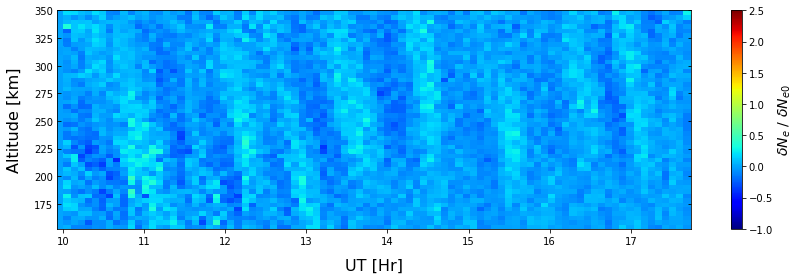

In [12]:
fig, ax = plt.subplots()
Ys,Xs = np.meshgrid(alt_slice,t_slice)
im = ax.pcolormesh(Xs,Ys,Ne_sliced, norm = colors.Normalize(vmin = -1, vmax=2.5), cmap = plt.get_cmap('jet'))
ax.tick_params(axis = 'y',right=True, labelright=False, direction='in')
cbar = fig.colorbar(im, orientation = "vertical", pad = .05)
cbar.set_label('$\delta N_e$ / $\delta N_{e0}$',fontsize = 14)
plt.xlabel('UT [Hr]',fontsize = 16, labelpad = 12)
plt.ylabel('Altitude [km]',fontsize = 16, labelpad = 12)
plt.tight_layout()
plt.savefig('relative_e_den_Negale_reg_spaced_alt_slice.png')

In [15]:
Z3.shape

(184, 90)

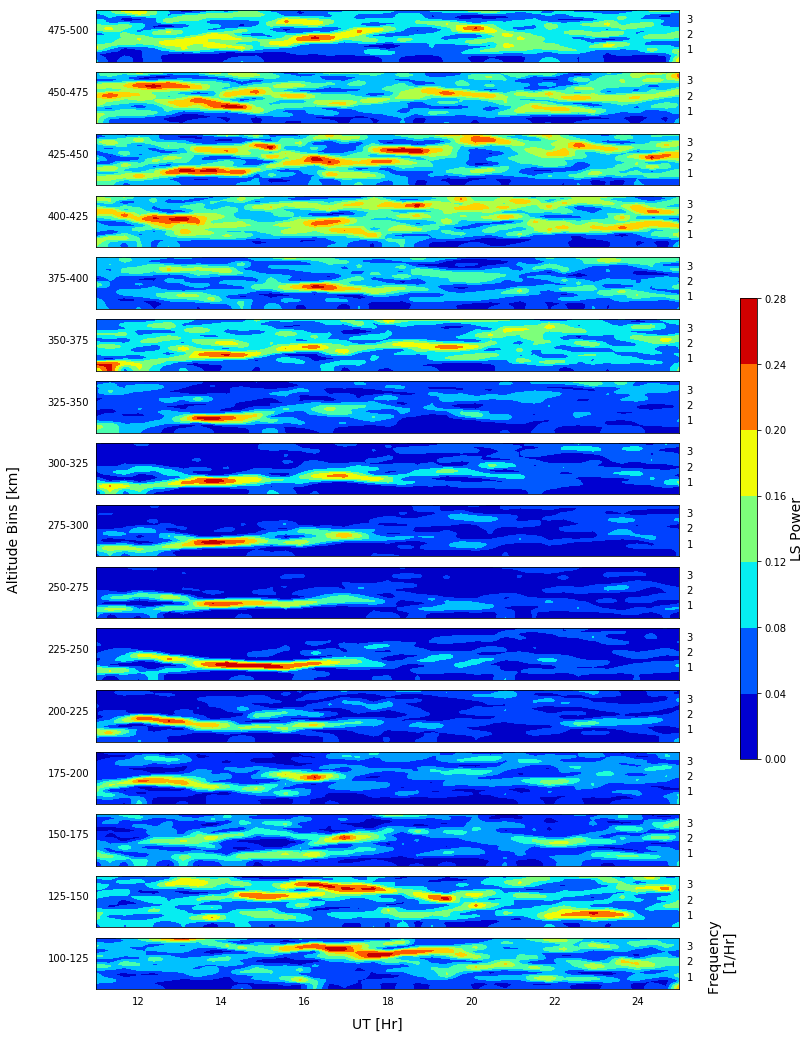

In [13]:
# Lomb Scargle Spectrogram
# plot parameters in order to make figure with multiple subplots (ie axes), which can be referenced 
fig_size = ['','']
fig_size[0] = 12
fig_size[1] = 16
plt.rcParams["figure.figsize"] = fig_size
fig, axes = plt.subplots(16, 1, sharex=True)
subplt_num = 15

rel_e_densities = rel_Ne_den_array[0,:,:] #beam 0 is used for filtered electron densities 
freq_len = 100 # number of elements in the frequency array 
frequency = np.linspace(.1,3.5,freq_len) # creating an array of frequency values that are in a physically reasonable range
t_power = np.zeros(41)
dx = t_power[1] - t_power[0]
dy = frequency[1] - frequency[0]
alt_num = 0
cmap = 'jet'
#---------------
for alt_bin in range(125,525,25): # subplots of the specrograms go up 25 km at a time, as done in the Negale MSTID section
    avg_spec = np.zeros((41,freq_len)) # initializing size for averaging specrogram, 41 is the len(t_power) (prob should have used
                                       # that instead), and freq_len is the length of the frequency array
                                       # this stores the average powers of the LS-specrogram as a function of time and frequency 
    norm = 0
    while(altitude_0_km[alt_num] < float(alt_bin)): # as talked about in negale paper, want to average spectrograms 
                                                    # in 25 km bins
        ti = 0 # used to move box-car windowing function along time domain 
        power_spec = np.zeros((41,freq_len)) # storing powers of a spectrogram for a specific altitude as function of 
                                             # time and frequency 
        for k in range(0,(len(t)-23),4): # 23 corresponds to a length of about 2 hours in the time array, t
                                         # then counting by 4 to move box-car window function about 20 min each time
            Ne_rel_bin = rel_e_densities[k:23+k,alt_num] # getting electron densities for a 2 hour time slice and 
                                                         # specific altitude 
            t_sample = t[k:23+k] # getting 2 hour time slice of time array
            t_power[ti] = t_sample[12] # time of the middle of the 2 hour slice
            power_spec[ti,:] = LombScargle(t_sample,Ne_rel_bin).power(frequency) # putting LS-periodogram into the 
                                                                    # specgrogram array for a specific time corresponding
                                                                    # to the middle of the 2 hour time slice, where the 
                                                                    # LS-power is a function of frequency
                                                                                
            ti += 1 #increasing indexer for box-car function by one
        avg_spec += power_spec # adding specific spectrogram to the averaging spectrogram, which averages 
                               # spectrograms in 25 km altitude bins
        alt_num += 1 # increasing the altitude indexer by one
        norm += 1 # increasing the variable used to normalize the spectrograms 
    avg_spec = (avg_spec / float(norm)) # normalizing the spectrogram array
    Yspec,Xspec = np.meshgrid(frequency,t_power) # creating a meshgrid out of the frequency and time-arrays
                                                 # note that t_power stores the times corresponding to the middle of each
                                                 # boxcar windowing function used for a specific altitude 
    # Plotting averaged spectrogram subplot for subplot
    # this is plotting stuff used to make figure that I wouldnt worry too much about understanding
    im2 = axes[subplt_num].contourf(Xspec + (dx/2.),Yspec + (dy/2.),avg_spec, cmap=cmap)
    y_subplot_str = str(alt_bin-25)+'-'+str(alt_bin)
    axes[subplt_num].set_ylabel(y_subplot_str,rotation=0,labelpad=28)
    axes[subplt_num].tick_params(
        axis = 'y',
        left=False,
        right=False,
        labelleft=False,
        labelright=True)
    axes[subplt_num].tick_params(
        axis = 'x',
        bottom=False)
    axes[subplt_num].set_xlim([11, 25])
    # Want to plot from bottom to top    
    subplt_num -= 1
fig.subplots_adjust(bottom=0.1, right=0.8, top=0.95)
cax1 = fig.add_axes([0.87,0.3,0.02,0.4])
cbar = plt.colorbar(im2,cax=cax1,orientation='vertical')
cbar.set_label('LS Power',fontsize=14)
fig.text(0.45, 0.07, 'UT [Hr]', ha='center', va='center', fontsize = 14)
fig.text(0.03, 0.5, 'Altitude Bins [km]', ha='center', va='center', rotation='vertical',fontsize = 14)
fig.text(0.85, 0.13,'Frequency \n [1/Hr]', ha='center', va='center', rotation='vertical',fontsize = 14)
fig.savefig('Spectrogram_MSTID')

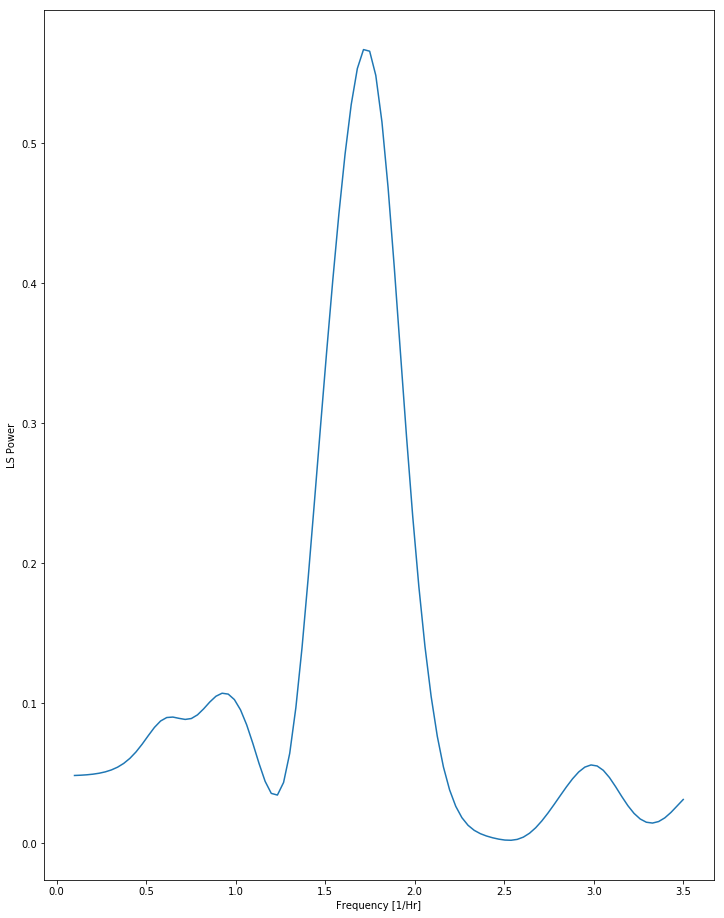

In [17]:
# Example of lomb scargle periodogram
time_a = np.linspace(t[0],t[-1],int(t.size))
ta = time_a[12:12+23]
R = rel_e_densities[12:23+12,29]
p = LombScargle(ta,R).power(frequency)
plt.plot(frequency,p)
plt.xlabel('Frequency [1/Hr]')
plt.ylabel('LS Power')
plt.savefig('LS.png')

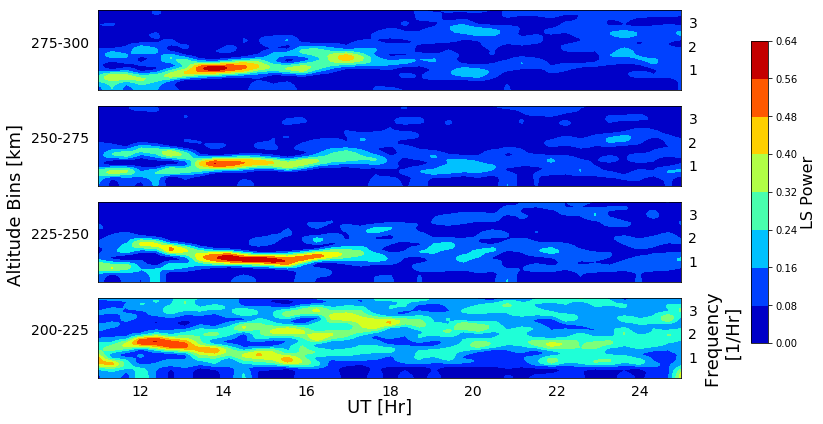

In [18]:
# Lomb Scargle Periodogram
fig_size = ['','']
fig_size[0] = 12
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
fig, axes = plt.subplots(4, 1, sharex=True)
subplt_num = 3


freq_len = 100
frequency = np.linspace(.1,3.5,freq_len)
t_power = np.zeros(41)
dx = t_power[1] - t_power[0]
dy = frequency[1] - frequency[0]
alt_num = 0
cmap = 'jet'
#---------------
for alt_bin in range(225,325,25):
    avg_spec = np.zeros((41,freq_len))
    norm = 0
    while(altitude_0_km[alt_num] < float(alt_bin)):
        ti = 0
        power_spec = np.zeros((41,freq_len))
        for k in range(0,(len(t)-23),4):
            Ne_rel_bin = rel_e_densities[k:23+k,alt_num]
            t_sample = t[k:23+k]
            t_power[ti] = t_sample[12]
            power_spec[ti,:] = LombScargle(t_sample,Ne_rel_bin).power(frequency)
            ti += 1
        avg_spec += power_spec
        alt_num += 1
        norm += 1
    avg_spec = (avg_spec / float(norm))
    Yspec,Xspec = np.meshgrid(frequency,t_power)
    # Plotting averaged spectrogram subplot for subplot
    im1 = axes[subplt_num].contourf(Xspec + (dx/2.),Yspec + (dy/2.),avg_spec, cmap=cmap)
    y_subplot_str = str(alt_bin-25)+'-'+str(alt_bin)
    axes[subplt_num].set_ylabel(y_subplot_str,rotation=0,labelpad=38,fontsize = 14)
    axes[subplt_num].tick_params(
        axis = 'y',
        left=False,
        right=False,
        labelleft=False,
        labelright=True,
        labelsize = 14)
    axes[subplt_num].tick_params(
        axis = 'x',
        bottom=False,
        labelsize = 14)
    axes[subplt_num].set_xlim([11, 25])
    # Want to plot from bottom to top    
    subplt_num -= 1
fig.subplots_adjust(bottom=0.1, right=0.8, top=0.95)
cax1 = fig.add_axes([0.88,0.18,0.02,0.7])
cbar = plt.colorbar(im1,cax=cax1,orientation='vertical')
cbar.set_label('LS Power',fontsize=16)
fig.text(0.45, 0.03, 'UT [Hr]', ha='center', va='center', fontsize = 18)
fig.text(0.03, 0.5, 'Altitude Bins [km]', ha='center', va='center', rotation='vertical',fontsize = 18)
fig.text(0.85, 0.195,'Frequency \n [1/Hr]', ha='center', va='center', rotation='vertical',fontsize = 18)
fig.savefig('Spectrogram_MSTID_slice.png')

In [20]:
# returns confidence level for 95% certainy that if a peak surpasses the 
# confidence level then peak isn't just from noise 
def false_alarm_conf_lvl(Pa,time_array,s):
    Ni = np.floor(len(time_array)/2.)
    Za = -(s**2)*np.log(1-(1-Pa)**(1./Ni))
    return Za

In [14]:
# Defining frequency and time arrays that will be used
time_array = t
freq_min = 1./(time_array[-1]-time_array[0])
N_freq = np.floor(len(time_array)/2.)
freq_max = N_freq*freq_min
freq = np.linspace(freq_min,freq_max,N_freq)

C:\Users\casey\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  


In [22]:
# Inputting data from one beam 
# Retaining data whose LS power spectrums that exceed 95% conf interval
# Also storing dominant periods of data

def conf_interval_fun(Pa,time_array,rel_e_den_array):
    time_range = rel_e_den_array.shape[0]
    alt_range = rel_e_den_array.shape[1]
    retained_Ne_data = np.zeros((time_range,alt_range))
    dominant_period_array = np.zeros(alt_range)
    for i in range(alt_range):
        # step through each altitude in rel_e_den_array
        rel_e_bin = rel_e_den_array[:,i]
        # Calc standard deviation of input data
        s = np.std(rel_e_bin)
        # Take LS power spectrum
        ls_power_spec = LombScargle(time_array,rel_e_bin,s).power(freq)
        # Calc 95 conf level
        za = false_alarm_conf_lvl(Pa,time_array,s)
        # Calc peak of LS
        ls_peak = 0
        ls_peak_index = 0
        for j in range(len(ls_power_spec)):
            if ls_peak < ls_power_spec[j]:
                ls_peak = ls_power_spec[j]
                ls_peak_index = j
        # Determine freq of peak to determine dominant period
        peak_freq = freq[ls_peak_index]
        dom_period = 1./peak_freq
        # If peak exceeds confidence level
        if ls_peak > za:
            # Retain array
            retained_Ne_data[:,i] = rel_e_bin
            # Set dominant_period_array to dominant period
            dominant_period_array[i] = dom_period
    return retained_Ne_data, dominant_period_array

In [22]:
rel_e_bin = rel_Ne_reg_spaced[0,:,0]
s = np.std(rel_e_bin)
ls_power_spec = LombScargle(t,rel_e_bin,s).power(freq)
za = false_alarm_conf_lvl(.95,t,s)

In [23]:
# Define function that retains data for beam pairings
# That meet the following requirements

# For each altitude bin in Ne array
    # 1. Both dominant periods are NOT zero
    # 2. Absolute difference between dominant periods
    #    is less than 10 minutes
def first_beam_sort(dominant_period_array1, dominant_period_array2, alt_range):
    retained_Ne_index = np.ones(alt_range)
    for i in range(alt_range):
        if (dominant_period_array1[i] == 0) or (dominant_period_array2[i] == 0):
            retained_Ne_index[i] = 0
        
        if np.abs(dominant_period_array1[i] - dominant_period_array2[i]) > (10./60.):
            retained_Ne_index[i] = 0
    
    return retained_Ne_index

In [24]:
# Filter data using beam pairs (2,3), (1,3), (1,0), (0,3)
    # where we retain beam pairs where:
    # 1. both dominant periods NOT equal to 0
    # 2. diff between periods less than 20 min
# Take complex cross-spectra for each beam pair
# Compare peak period of spectrum with dominant periods of each beam seperately
# If periods differ by more than 10 minutes then data is also not used
# From cross- spectra (csd) also obtain errors in phase delay
    # This is the FWHM of cross-spectra centered on dominant wave period 
# During process also obtain phase delay of beam pair signals for retained data
    #phase delay determined by argmax of cross-correlation of signals 
# y = phase delay
# C = Coerror matrix, diagonal matric
#
# Variables I will prob use:
#
# t: time array
# alt_reg_spaced: altitude array
# rel_Ne_reg_spaced: Ne array
# freq_min: sampling frequency 
# Functions I will prob use:
#
# conf_interval_fun(Pa,time_array,rel_e_den_array)
# first_beam_sort(dominant_period_array1, altitude_array_1,dominant_period_array2,altitude_array_2)
#

phase_delay = 0
phase_delay_err = 0
beam_pair_len = 6
Pa = .95
beam_pairs = [(0,1),(0,2),(0,3),(1,2),(1,3),(2,3)]
fs = 1./(t[1]-t[0]) # sampling frequency 
# Retaining data that passes confidence test
retained_Ne_array = np.zeros((beam_pair_len,time_size,alt_size))
dom_period_array = np.zeros((beam_pair_len,alt_size))
alt_km_array = altitude[:,alt_start:alt_end] / 1000.

phase_delay_array = np.zeros((beam_pair_len,alt_size))
phase_delay_err_array = np.zeros((beam_pair_len,alt_size))
for i in range(4):
    retained_Ne_array[i,:,:], dom_period_array[i,:] = conf_interval_fun(Pa,t,rel_Ne_reg_spaced[i,:,:])
beam_pair_num = 0    
for item in beam_pairs:
    beam1, beam2 = item
    retained_Ne_index_array = first_beam_sort(dom_period_array[beam1,:],dom_period_array[beam2,:],alt_size)
    for i in range(alt_size):
        # only use data whose dom_period_array is nonzero
        if retained_Ne_index_array[i] != 0:
            # Take complex cross-spectra for each beam pair
            x = retained_Ne_array[beam1,:,i]
            y = retained_Ne_array[beam2,:,i]
            # actually might want to calculate the cohherence ???
            f, Pxy = csd(x,y,fs,scaling = 'spectrum')
            # test peak of cross spectrum against conf interval 
            s = np.std(Pxy)
            za = false_alarm_conf_lvl(Pa,t,s) # conf lvl
            if np.abs(np.amax(Pxy)) > za:
                # Compare peak period of spectrum with dominant periods of each beam seperately
                # If periods differ by more than 10 minutes then data is also not used
                peak_index = np.argmax(np.abs(Pxy))
                cross_spec_period = 1./f[peak_index]
                if np.abs(dom_period_array[beam1,i] - cross_spec_period) < (10./60.) and \
                   np.abs(dom_period_array[beam2,i] - cross_spec_period) < (10./60.):
                    # obtain phase delay of beam pair signals for retained data using argmax of csd 
                    phase_delay = np.angle(Pxy[peak_index])
                    # From csd also obtain errors in phase delay
                        # This is the FWHM of cross-spectra centered on dominant wave period 
                    HM = Pxy[peak_index] / 2. # Half maximum
                    # Initializing differences used to determine FWHM
                    min_diff1 = np.abs(HM - Pxy[peak_index])+1
                    min_diff2 = np.abs(HM - Pxy[peak_index])+1
                    a1 = 0
                    a2 = 0
                    for j in range(int(np.floor(len(Pxy)/2.))):
                        if peak_index-j > 0 and peak_index+j < len(Pxy):
                            diff1 = np.abs(HM - Pxy[(peak_index-j)])
                            diff2 = np.abs(HM - Pxy[(peak_index+j)])
                            # second condition used to ensure that it stays within original peak
                            if diff1 < min_diff1 and j == a1: 
                                min_diff1 = diff1
                                HM_index1 = peak_index-j
                                a1 += 1
                            if diff2 < min_diff2 and j == a2:
                                min_diff2 = diff2
                                HM_index2 = peak_index+j
                                a2 += 1
                            phase_delay_err = np.angle(Pxy[HM_index2])- np.angle(Pxy[HM_index1])
            # inputting data into array
            phase_delay_array[beam_pair_num,i] = phase_delay
            phase_delay_err_array[beam_pair_num,i] = phase_delay_err
        else:
            phase_delay_array[beam_pair_num,i] = 0
            phase_delay_err_array[beam_pair_num,i] = 0 
    beam_pair_num += 1

/usr/local/lib/python2.7/dist-packages/scipy/signal/spectral.py:1773: UserWarning: nperseg = 256 is greater than input length  = 184, using nperseg = 184
  .format(nperseg, input_length))


In [25]:
# defining dictionary to store beam angles (spherical polar coord will be used)
proj_dict = {}
proj_dict['theta0'] = 90.0
proj_dict['theta1'] = 77.5
proj_dict['theta2'] = 66.09
proj_dict['theta3'] = 65.56
proj_dict['phi0'] = 14.04
proj_dict['phi1'] = -154.3
proj_dict['phi2'] = -34.69
proj_dict['phi3'] = 75.03

for i in proj_dict:
    proj_dict[i] = (2*np.pi*proj_dict[i])/360.

In [26]:
# defining propagation direction function 
# which inputs beam numbers, beam1 and beam2, and alt_step as ints
def propagation_dir_fun(beam1,beam2,alt_step):
    theta1 = proj_dict['theta{}'.format(beam1)]
    phi1 = proj_dict['phi{}'.format(beam1)]
    theta2 = proj_dict['theta{}'.format(beam2)]
    phi2 = proj_dict['phi{}'.format(beam2)]
    prop_dir = alt_reg_spaced[alt_step]*np.array([np.cos(theta1)*np.cos(phi1)-np.cos(theta2)*np.cos(phi2),np.cos(theta1)*np.sin(phi1)-np.cos(theta2)*np.sin(phi2),np.sin(theta1)-np.sin(theta2)])
    return prop_dir

In [27]:
# calculate k vector for each altitude bin

# Variables I might need
# alt_reg_spaced
# phase_delay_array


# for each altitude bin
k = np.zeros((alt_size,3))
for i in range(alt_size):
    # for each beam pair
    # define propagation, A, matrix
    # define error matrix, C, matrix
    # define phase, y, vector 
    A_array = []
    C_vector = []
    y_vector = []
    b_num = 0 # beam pair index
    for item in beam_pairs:
        beam1, beam2 = item
        if phase_delay_array[b_num,i] != 0:
            # Define propagation direction Ai
            Ai = propagation_dir_fun(beam1,beam2,i)
            A_array.append(Ai)
            Ci = phase_delay_err_array[b_num,i] #phase delay err
            C_vector.append(Ci)
            yi = phase_delay_array[b_num,i] # phase delay
            y_vector.append(yi)
        b_num += 1
    # check to see if A_array is empty
    if len(A_array) != 0:
        # Define matrixes and change to array
        y = np.array(y_vector)
        # creating diagonal error matrix
        C_size = len(C_vector)
        C = np.zeros((C_size,C_size))
        for j in range(C_size):
            C[j,j] = C_vector[j]
        # creating propagation direction matrix
        A = np.array(A_array)
        # calculate k
        C = np.matrix(C)
        if np.isinf(np.linalg.cond(C)) != True and len(C) > 1:
            A = np.matrix(A)
            y = np.transpose(np.matrix(y))
            A_T = np.transpose(A)
            C_inv = np.linalg.inv(C)
            ki = np.linalg.inv(A_T*C_inv*A)*A_T*C_inv*y
            ki2 = np.array(ki)
            k[i,:] = ki2[:,0]
            

LinAlgError: Singular matrix

In [ ]:
kx_a= k[:,0]
ky_a = k[:,1]
kzr_a = k[:,2]
kx_IC = np.average(kx_a[kx_a != 0])
ky_IC = np.average(ky_a[ky_a != 0])
kzr_IC = np.average(kzr_a[kzr_a != 0])
print kx_IC, ky_IC, kzr_IC

In [ ]:
# Define background used by Hooke model
# Define a function that maps the background electron densities onto an evenly
# spaced altitude array for each beam 
# 
# Use regularly spaced background electron densities (that matchup with rel_e_densities)
# in Hooke model to calculate the relative electron densities predicted by the Hooke model 

In [ ]:
# Parameters for Ne pertubation based off 1968 Hooke paper eqn 51
# Poker Flat Location Parameters
# Latitude: 65° 07' 12.00" N
# Longitude: -147° 28' 12.00" W
# 65.12 -147.47
# Magnetic Inclination: 76.2620° 


Z,T = np.meshgrid(alt_reg_spaced,t)
Ne0z = Ne_background_reg_spaced[0,:,:]


I = 76.2620/360. # Magnetic inclination, radians 
 
kbr = 0
kx = kx_IC
kzr = kzr_IC
H = 50000. #approx scale height in F2 region of ionosphere
kzi = - 1./(2*H) # 1/m
gamma = 1.4
g = 9.08
c0_sq = gamma*g*H # Speed of sound in neutral gas squared
wb_sq = (gamma-1)*(g**2/c0_sq)
dNe0dz = np.array(np.gradient(Ne0z, alt_reg_spaced, axis = 1))

#Hines dispersion relation, where w is x
def disp(x):
    return x**2 - x*c0_sq*(kx**2 + kzr**2) + (gamma-1)*(g**2)*(kx**2) - ((gamma*g*x)**2)/(4*c0_sq)

# Initial Guess for w, want period around 1 Hr, thus
w_guess = (2*np.pi/(60*60))**2
w2 = fsolve(disp,w_guess)
w = np.sqrt(w2[0])

# We want units in terms of Hr and km
z0 = 250. #starting height in atmosphere, km
w = w*60*60
kx = kx*1000.
kzi = kzi*1000.
kzr = kzr*1000.
Ubz0 = 75*((60.*60.)/1000.) #Guess based off Hooke paper
print 'C',np.sqrt(c0_sq),'\n','kx',kx,'\n','w',w

# Ne pertubation model, as a function of time, T, and altitude, Z
Ne_prime =  Ne0z*Ubz0*np.sin(I)*np.exp(kzi*(Z-z0))*(w**(-1))*np.sqrt( ((1./Ne0z)*dNe0dz + kzi)**2)*np.cos(w*T-1*(kzr*Z)+np.pi/2)

Ne_rel_H = Ne_prime / Ne0z #relative pertubation in ionosphere
N = 10
plt.contourf(T,Z,Ne_rel_H, N, cmapcmap='jet')
plt.xlabel('Time [Hr]',fontsize = 16)
plt.ylabel('Altitude [m]', fontsize = 16)
cbar = plt.colorbar()
cbar.set_label('$\delta N_e$ / $\delta N_{e0}$',fontsize=14)
plt.savefig('Hooke_Model_aprox.png')

In [ ]:
Bx0_array = Bx_array[0,:]
By0_array = By_array[0,:]
Bz0_array = Bz_array[0,:]

In [ ]:
Bx0_array = Bx0_array[~np.isnan(Bx0_array)]
By0_array = By0_array[~np.isnan(By0_array)]
Bz0_array = Bz0_array[~np.isnan(Bz0_array)]

In [ ]:
Bx = np.average(Bx0_array)
By = np.average(By0_array)
Bz = np.average(Bz0_array)

In [ ]:
B0_array = np.array([Bx,By,Bz])
Bu0 = B0_array / np.linalg.norm(B0_array)

In [ ]:
np.dot([kx_IC,ky_IC,kzr_IC],Bu0)

# Fitting Process

In [19]:
alt_slice = 1000*alt_reg_spaced[13:63] # m
t_slice = t[0:90]*(60.*60.) # s
Ne_sliced = rel_Ne_reg_spaced[0,0:90,13:63]
Zs,Ts = np.meshgrid(alt_slice,t_slice)

In [31]:
def hooke_model(w,kzr,Z,T,Ne0z):
    
    Ubz0 = 10. # m/s
    # kx = np.sqrt(kx_IC**2+ky_IC**2)
    I = 76.2620*(np.pi/180.) # Magnetic inclination, radians 
    
    kbr = 0
    # kbr = np.dot([.02,.02,kzr],Bu0)
    # Ubz0 = 75.*((60.*60.)/1000.)
     
    H = 50.*1000. #approx scale height in F2 region of ionosphere, in m
    kzi = (-1./(2*H)) # 1/m

    # gamma = 1.4
    # g = 9.08
    # c0_sq = gamma*g*H_m # Speed of sound in neutral gas squared
    # wb_sq = (gamma-1)*(g**2/c0_sq)
    dNe0dz = np.array(np.gradient(Ne0z, alt_slice, axis = 1))

    #Hines dispersion relation, where w is x
    #    def disp(x):
    #       return x**2 - x*c0_sq*(kx_m**2 + kzr_m**2) + (gamma-1)*(g**2)*(kx_m**2) - ((gamma*g*x)**2)/(4*c0_sq)

    # Initial Guess for w, want period around 1 Hr, thus
    # w_guess = (2*np.pi/(60*60))**2
    # w2 = fsolve(disp,w_guess)
    # w = np.sqrt(w2[0])

    # We want units in terms of Hr and km
    z0 = 100.*1000. #starting height in atmosphere, m

    # Ne pertubation model, as a function of time, T, and altitude, Z
    Ne_prime =  Ne0z*Ubz0*np.sin(I)*np.exp(kzi*(Z-z0))*(w**(-1))*np.sqrt( ((1./Ne0z)*dNe0dz + kzi)**2 + (kbr/np.sin(I))**2 )*np.cos(w*T-(kzr*Z)+np.pi/2 - np.arctan(kbr/(np.sin(I)*((1./Ne0z)*dNe0dz+kzi))))

    Ne_rel_H = Ne_prime / Ne0z #relative pertubation in ionosphere
    
    return Ne_rel_H

In [21]:
# define error function of Hooke Model that will be optimized
# to minimize the error between Hooke Model and PFISR Data

# where x is the array of input parameters that will be adjusted
 
def err_Hooke_Model(x,yData,Ne_background):
    w = x[0]
    kzr = x[1]
    yModel =  hooke_model(w,kzr,Zs,Ts,Ne_background)
    
    res = yData - yModel
    res_array = np.reshape(res,(len(alt_slice)*len(t_slice),))
    return res_array

In [22]:
#defining initial guess and function arguments
#Ubz0_ic = 10
w_ic = 5*(1./(60.*60.))
kzr_ic = -.01247*(1./1000.)
x0 = np.array([w_ic,kzr_ic])
#bounds = ((-np.inf,1,.01),(np.inf,10,.1))
args = (Ne_sliced,background_Ne_sliced)

In [23]:
# solving, I should define bounds for soln

# bound for negative value 
ls_soln = least_squares(err_Hooke_Model,x0,args=args,max_nfev=1000)

In [24]:
print(ls_soln)

 active_mask: array([0., 0.])
        cost: 26.38817690454079
         fun: array([-0.05468562, -0.00878183, -0.08245429, ..., -0.0570778 ,
       -0.03362647, -0.0381527 ])
        grad: array([  29.34155332, -128.33447925])
         jac: array([[  3327.5651453 , -14034.9736141 ],
       [   765.94105936,  -3317.8224704 ],
       [  5364.74327756, -23849.82204481],
       ...,
       [   177.99747275,   -980.82258249],
       [   130.04524368,   -726.5496602 ],
       [    51.07632312,   -289.37386763]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 44
        njev: 41
  optimality: 128.33447924642405
      status: 3
     success: True
           x: array([ 1.36921017e-03, -5.14562131e-06])


In [25]:
p_array = ls_soln.x
print('Final w, kzr', p_array)
print('Initial w, kzr', x0)

Final w, kzr [ 1.36921017e-03 -5.14562131e-06]
Initial w, kzr [ 1.38888889e-03 -1.24700000e-05]


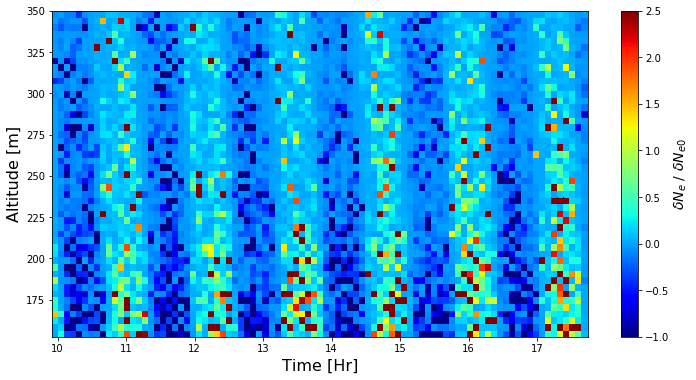

In [32]:
#plotting on pcolormesh what hooke model looks like with optimized values
fig_size = ['','']
fig_size[0] = 12
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

Ne_rel_H2 = hooke_model(p_array[0],p_array[1],Zs,Ts,Ne_sliced)
N = 10

plt.rcParams["figure.figsize"] = fig_size
plt.pcolormesh(Ts/(60.*60.),Zs/1000.,Ne_rel_H2,norm = colors.Normalize(vmin = -1, vmax=2.5), cmap = plt.get_cmap('jet'))
plt.xlabel('Time [Hr]',fontsize = 16)
plt.ylabel('Altitude [m]', fontsize = 16)
cbar = plt.colorbar()
cbar.set_label('$\delta N_e$ / $\delta N_{e0}$',fontsize=14)
plt.savefig('Hooke_Model_aprox.png')

# Chi-Squared Goodness of Fit

In [33]:
n_pts = Ne_sliced.size
n_parms = 2
v = n_pts - n_parms-1 # degrees of freedom 

In [113]:
Ne_error.shape

(511, 4, 180)

In [34]:
time_start = 110
time_end = 294
time_size = time_end - time_start
alt_start = 36
alt_end = 126
alt_size = alt_end - alt_start

In [35]:
Ne_error_0 = Ne_error[time_start:time_end,0,alt_start:alt_end]
Ne_error_0_slice = Ne_error_0[0:90,13:63]

In [36]:
Ne_error_0_slice_flat = np.reshape(Ne_error_0_slice,(len(alt_slice)*len(t_slice),))
n_error = int(Ne_error_0_slice_flat.size)

Ne_rel_sliced_flat = np.reshape(Ne_sliced,(len(alt_slice)*len(t_slice),))

In [37]:
def chi_sq_fun(w,k):
    Ne_rel_model = hooke_model(w,k,Zs,Ts,Ne_sliced)
    Ne_rel_model_flat = np.reshape(Ne_rel_model,(len(alt_slice)*len(t_slice),))
    chi_sq = 0
    for i in range(n_error):
        frac_err = Ne_error_0_slice_flat[i]
        if math.isnan(frac_err) == False:
            Ne_model = Ne_rel_model_flat[i]
            Ne_data = Ne_rel_sliced_flat[i]
            sd = frac_err
            chi_sq_i = ((Ne_data-Ne_model)/sd)**2
            chi_sq = chi_sq + chi_sq_i
    return chi_sq

In [36]:
chi_sq_fun(5,.1)

0.004696482158575609

In [62]:
w_array = np.linspace(120,140,50)*(1./(60.*60.))
kzr_array = np.linspace(-.1,.1,50)*(1./1000.)
chi_sq_array = np.zeros((50,50))

In [63]:
for i in range(50):
    w = w_array[i]
    for j in range(50):
        k = kzr_array[j]
        chi_sq_array[i,j] = chi_sq_fun(w,k)
        

In [45]:
chi_sq_fun(5,10)

31477903.836674325

In [41]:
chi_sq_fun(5,-.1)

35634353.541074626

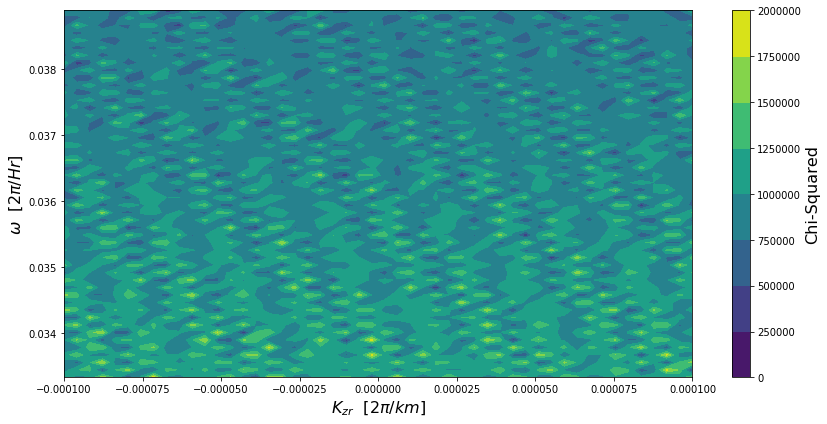

In [64]:
fig_size = ['','']
fig_size[0] = 12
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
im4 = plt.contourf(kzr_array,w_array,chi_sq_array)
cb4 = plt.colorbar()
cb4.set_label('Chi-Squared',fontsize=16)
plt.xlabel('$K_{zr} \ \ [2\pi / km]$', fontsize=16 )
plt.ylabel('$\omega \ \ [2\pi / Hr]$', fontsize=16)
plt.tight_layout()
plt.savefig('chi_dist.png',dpi=400)

In [178]:
DoF = num_val - n_parms - 1
print 'Chi - Squared Value:', chi_sq
print 'Degree of Freedom:', DoF

Chi - Squared Value: 24782332.86538646
Degree of Freedom: 4497


In [156]:
np.set_printoptions(threshold=np.inf)

In [ ]:
# chi-squared surface for w and kz for multiple values of Ubz0

## Plots for different values of A, w, kzr

In [ ]:
print kzr_IC

In [ ]:
print w

TypeError: hooke_model() takes exactly 5 arguments (4 given)

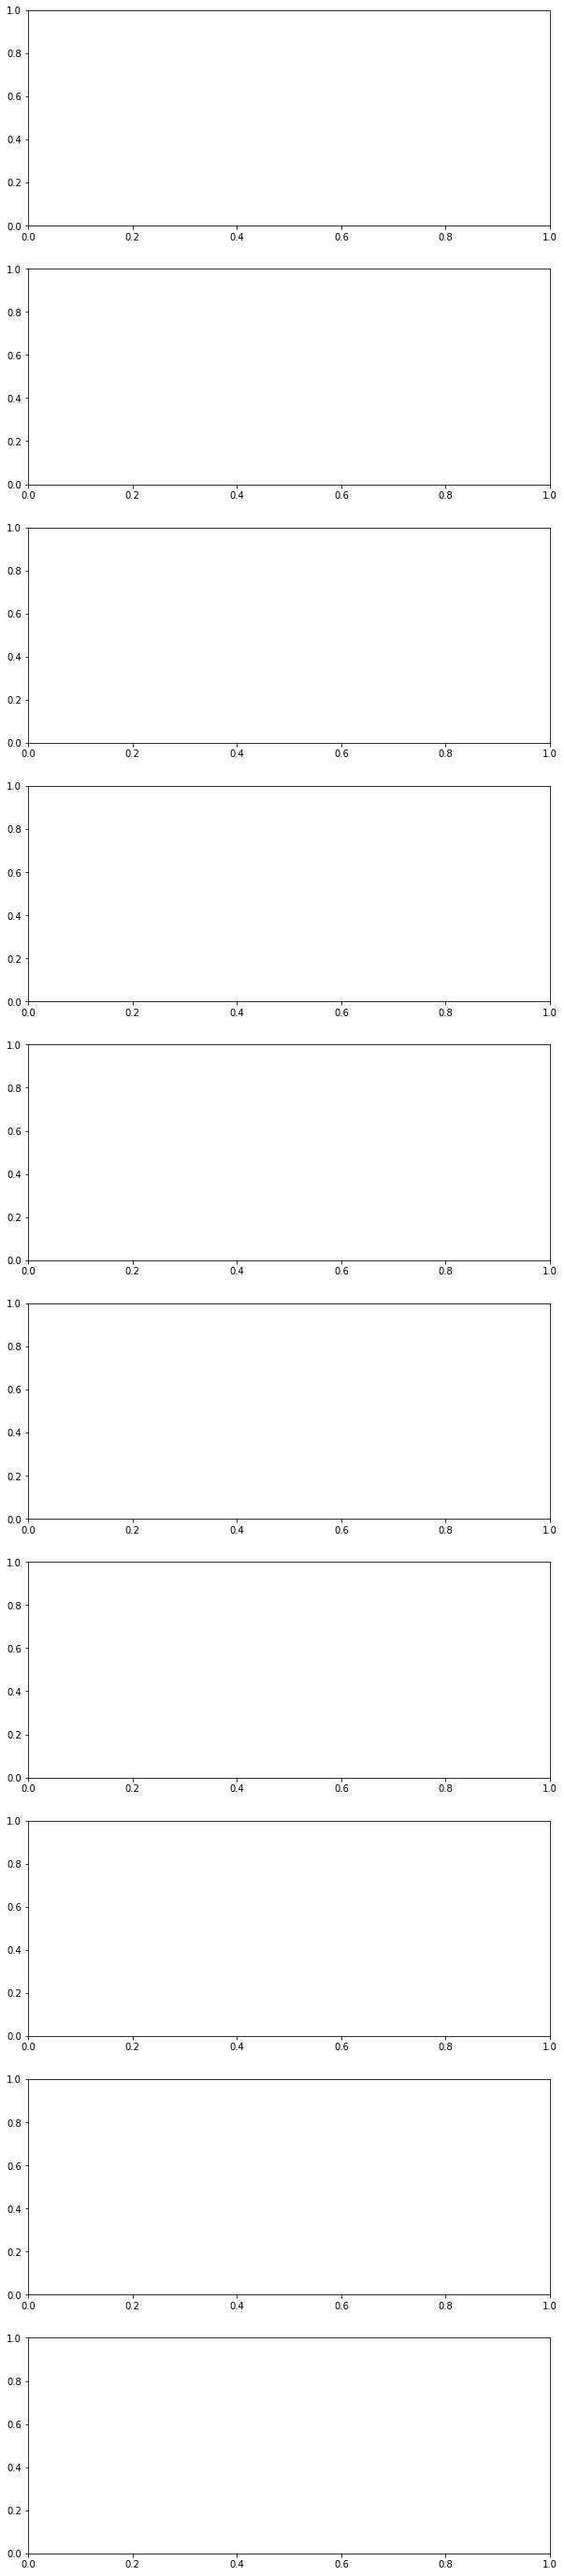

In [43]:
fig_size = ['','']
fig_size[0] = 10
fig_size[1] = 50
plt.rcParams["figure.figsize"] = fig_size
fig, axes = plt.subplots(10,1,sharey=True)
Ubz0 = 100
kzr = .057
w = 4.5
for i in range(10):
    Ne_plot = hooke_model(Ubz0,w,kzr,Ne_sliced)
    kzr = kzr + .1
    axes[i].contourf(T,Z,Ne_plot, N, cmapcmap='jet')

## Animation 
For changing values of angular frequency, w, and vertical wave vector, kzr

In [46]:
%matplotlib tk

In [44]:
Ubz0 = 10
Zs,Ts = np.meshgrid(alt_slice,t_slice)

# initial guesses for kzr and w based off properties of measured MSTIDS
# from Negele paper 
kzr_g = (-(2.*np.pi)/253.)
w_g = ((2.*np.pi)/(57./60.))

interval=1
frame_num = 800
Ne_plot_data = np.zeros((len(t_slice),len(alt_slice),frame_num))
value_array = np.zeros((2,frame_num))
kzr = .5*kzr_g
n= 0 
for i in range(20):
    w = .5*w_g
    for j in range(40):
        Ne_plot_data[:,:,n] = hooke_model(w,kzr,Zs,Ts,Ne_sliced)
        value_array[:,n] = (w,kzr)
        w = w + .5*(w_g/10.)
        n = n + 1
    kzr = kzr + (kzr_g/10.)
    

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

N = 20
# Positioning colorbars
div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '5%')

cf = ax.contourf(Ts,Zs,Ne_plot_data[:,:,0], N, camp='jet')
cb = fig.colorbar(cf, cax=cax)
w0,kzr0 = value_array[:,0]
tx = ax.set_title('Plot %03d: w = %f [$2 \pi$/Hr], kzr = %f [1/km]' % (0,w0,kzr0))

def animate2(i):
    arr = Ne_plot_data[:,:,i]
   # vmax     = np.max(arr)
   # vmin     = np.min(arr)
   # levels   = np.linspace(vmin, vmax, 10, endpoint = True)
    cf = ax.contourf(Ts,Zs,arr, N,norm = colors.Normalize(vmin = -1, vmax=1), cmap='jet')
    cax.cla()
    fig.colorbar(cf, cax=cax)
    w,kzr = value_array[:,i]
    tx.set_text('Plot %03d: w = %f [$2 \pi$/Hr], kzr = %f [1/km]' % (i,w,kzr))

ani = animation.FuncAnimation(fig,animate2,frame_num,interval=interval*1e+3,blit=False)

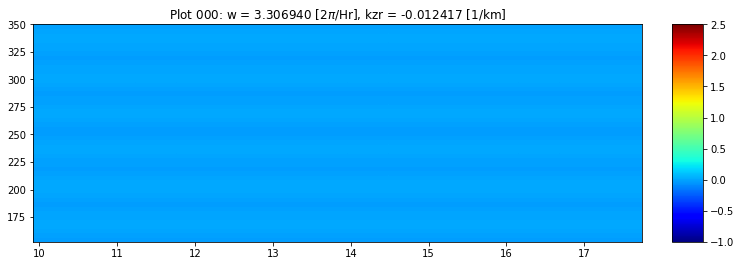

In [47]:
# color mesh looks promising
fig_size = ['','']
fig_size[0] = 12
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

fig = plt.figure()
ax = fig.add_subplot(111)

# Positioning colorbars
div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '5%')

pm = ax.contourf(Ts,Zs,Ne_plot_data[:,:,0], norm = colors.Normalize(vmin = -1, vmax=2.5), cmap = plt.get_cmap('jet'))
cb = fig.colorbar(pm, cax=cax)
w0,kzr0 = value_array[:,0]
tx = ax.set_title('Plot %03d: w = %f [$2 \pi$/Hr], kzr = %f [1/km]' % (0,w0,kzr0))



def animate3(i):
    arr = Ne_plot_data[:,:,i]
   # vmax     = np.max(arr)
   # vmin     = np.min(arr)
   # levels   = np.linspace(vmin, vmax, 10, endpoint = True)
    pm = ax.pcolormesh(Ts,Zs,arr, norm = colors.Normalize(vmin = -1, vmax=2.5), cmap = plt.get_cmap('jet')) 
    cax.cla()
    fig.colorbar(pm, cax=cax)
    w,kzr = value_array[:,i]
    tx.set_text('Plot %03d: w = %f [$2 \pi$/Hr], kzr = %f [1/km]' % (i,w,kzr))

ani_colormesh = animation.FuncAnimation(fig,animate3,frame_num,interval=interval*1e+3,blit=False)

In [ ]:
# Chi-Squared Goodness of Fit Test


## Example Code for Animation

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

# I like to position my colorbars this way, but you don't have to
div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '5%')

def f(x, y):
    return np.exp(x) + np.sin(y)

x = np.linspace(0, 1, 120)
y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)

frames = []
for i in range(10):
    x       += 1
    curVals  = f(x, y)
    frames.append(curVals)

cv0 = frames[0]
cf = ax.contourf(cv0, 200)
cb = fig.colorbar(cf, cax=cax)
tx = ax.set_title('Frame 0')

def animate(i):
    arr = frames[i]
    vmax     = np.max(arr)
    vmin     = np.min(arr)
    levels   = np.linspace(vmin, vmax, 200, endpoint = True)
    cf = ax.contourf(arr, vmax=vmax, vmin=vmin, levels=levels)
    cax.cla()
    fig.colorbar(cf, cax=cax)
    tx.set_text('Frame {0}'.format(i))

ani = animation.FuncAnimation(fig, animate, frames=10)

plt.show()

## Random Code

In [ ]:
print (2*np.pi) / 300
print kx_IC
print ky_IC

In [ ]:
Ne_background_reg_spaced[0,:,:].shape

In [ ]:
def beam_angles(beam1,beam2):
    theta = proj_dict['theta{}'.format(beam1)]
    phi = proj_dict['phi{}'.format(beam2)]
    return theta, phi

In [ ]:
# alt_reg_spaced,Ne_background_reg_spaced,rel_Ne_reg_spaced,t

# Note: For M[i][j], M[i] stores all the mesh grids for a specific beam, and M[i][j] has the corresponding
# X,Y,Z,T (j=0,..,3) meshgrid for that specific i beam
M = []
Ne0_list = []
x_array = np.zeros((4,alt_size))
y_array = np.zeros((4,alt_size))
for i in range(4):
    theta, phi = beam_angles(i,i)
    for j in range(alt_size):
        R = (1000.*alt_reg_spaced[j])/np.sin(theta)
        x_array[i,j] = R*np.cos(theta)*np.cos(phi)
        y_array[i,j] = R*np.cos(theta)*np.sin(phi)
    [X,Y,Z,T] = np.meshgrid(x_array,y_array,alt_reg_spaced,t,sparse=True)
    #[X1,Y1,Z1] = np.meshgrid(x_array,y_array,Ne_background_reg_spaced,sparse=True)
    M.append([X,Y,Z,T])
    #Ne0_list.append([X1,Y1,Z1])

In [ ]:
# create a function that takes in background Ne and uses 2D slice
# to align with 4D meshgrid of X,Y,Z,T

In [ ]:
x = np.arange(0,3)
y = np.arange(0,4)
Xp,Yp = np.meshgrid(x,y)

In [ ]:
r = np.arange(0,5)
Xi,Yi,Zi = np.meshgrid(r,Xp,Yp)

In [ ]:
# define Hooke Model as a functinon of 
    # k from which you get kx,ky,kzr,kzi
    # X,Y,Z determined by beam orrentation and grid size
    # T same for all beams
    # input background density, Ne_background
    # gravity wave amiplitude, Ubz0
# function returns perturbed background Ne, (Ne_prime), and angular frequency, (w)
def hooke_model(alt_re,Y,Z,T,k,Ubz0,Ne_background):
    
    I = 76.2620/360. # radians 
    z0 = 250000 #initial height
    H = 50000 #Scale height, m
    gamma = 1.4
    g = 9.08
    c0_sq = gamma*g*H # Speed of sound in neutral gas squared
    wb_sq = (gamma-1)*(g**2/c0_sq)
    dNe0dz = np.array(np.gradient(Ne0z, z, axis = 1))
    kbr = 0 #dot product of k and 1B, the unit vector of magnetic field
    kx = k1[0]
    kzr = k1[2]
    #Hines dispersion relation, where w is x
    def disp(x):
        return x**2 - x*c0_sq*(kx**2 + kzr**2) + (gamma-1)*(g**2)*(kx**2) - ((gamma*g*x)**2)/(4*c0_sq)
    w2 = fsolve(disp,w_guess)
    w = np.sqrt(w2[0])
    
    Ne_prime = Ne0z*Ubz0*np.sin(I)*np.exp(kzi*(Z-z0))*(w**(-1))*np.sqrt( ((1./Ne0z)*dNe0dz + kzi)**2)*np.cos(w*T-1*(kx*X+ky*Y+kzr*Z)+np.pi/2)
    return Ne_prime

In [ ]:
Ne_beam_0 = rel_Ne_reg_spaced[0,:,:]

In [ ]:
# Sampling box function

def sample_box(beam_array,model,beam_N,time_len,x_len,z_len):
    Ne_prime_sampled = np.zeros(beam_N,time_len,x_len,y_len,z_len)
    for beam_num in range(beam_N):
        Ne_prime_sampled[beam_num,:,:,:,:] = model(X,Y,Z,T,kx,ky,kzr,kzi,Ubz0)
            